# CART - classificatoin and regression trees

In [1]:
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

matplotlib.style.use("ggplot")
plt.rcParams["figure.figsize"] = [16, 9]
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import numpy as np
from matplotlib.colors import ListedColormap


def plot_decision(X, y, classifier, test_idx=None, resolution=0.02, figsize=(6,6)):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('#cc0000', '#003399', '#00cc00', '#999999', '#66ffff')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # get dimensions
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    xmin = xx1.min()
    xmax = xx1.max()
    ymin = xx2.min()
    ymax = xx2.max()
    
    # create the figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # plot the decision surface
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap, zorder=1)
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                   y=X[y == cl, 1],
                   alpha=0.6, 
                   c=cmap(idx),
                   edgecolor='black',
                   marker='o',#markers[idx],
                   s=50,
                   label=cl,
                   zorder=3)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c='w',
                   alpha=1.0,
                   edgecolor='black',
                   linewidths=1,
                   marker='o',
                   s=150, 
                   label='test set',
                   zorder=2)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import pydotplus


fruits = pd.read_table('fruits/fruit_data_with_colors.txt') #?
y = fruits.fruit_label
X = fruits[["width", "height"]]

In [4]:
X[:5]

,width,height
0,8.4,7.3
1,8.0,6.8
2,7.4,7.2
3,6.2,4.7
4,6.0,4.6


In [5]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# train the decision tree
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dtree.fit(X_train, y_train)

strong_dtree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=0)
strong_dtree.fit(X_train, y_train)

# use the model to make predictions with the test data
y_pred_test = dtree.predict(X_test)
y_pred_train = dtree.predict(X_train)

# Model evaluation

In [8]:
# how did our model perform?
count_misclassified = (y_test != y_pred_test).sum()
print('Misclassified samples: {}'.format(count_misclassified))

test_accuracy = accuracy_score(y_test, y_pred_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
print('Training accuracy: {0:.2f}, evaluation accuracy: {1:.2f}'.format(train_accuracy, test_accuracy))

Misclassified samples: 4
Training accuracy: 0.94, evaluation accuracy: 0.67


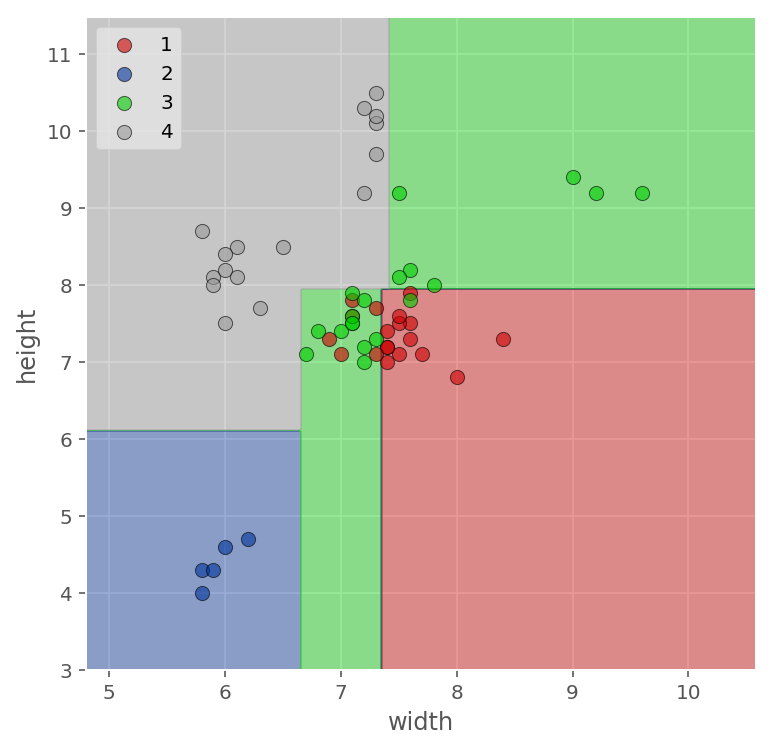

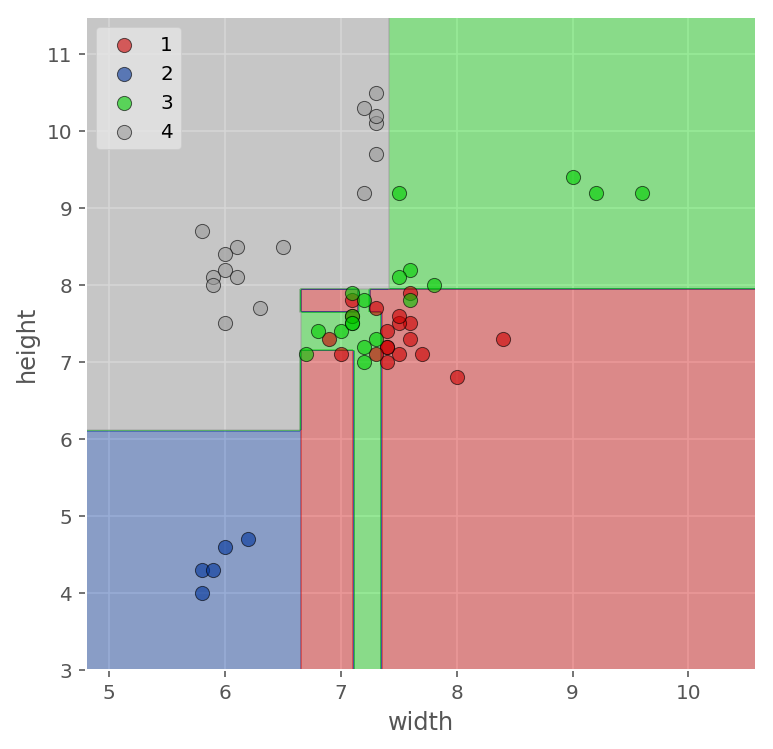

In [9]:
# visualize the model's decision regions to see how it separates the samples
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision(X=X_combined, y=y_combined, classifier=dtree)
plt.xlabel('width')
plt.ylabel('height')
plt.legend(loc='upper left')
plt.show()

plot_decision(X=X_combined, y=y_combined, classifier=strong_dtree)
plt.xlabel('width')
plt.ylabel('height')
plt.legend(loc='upper left')
plt.show()

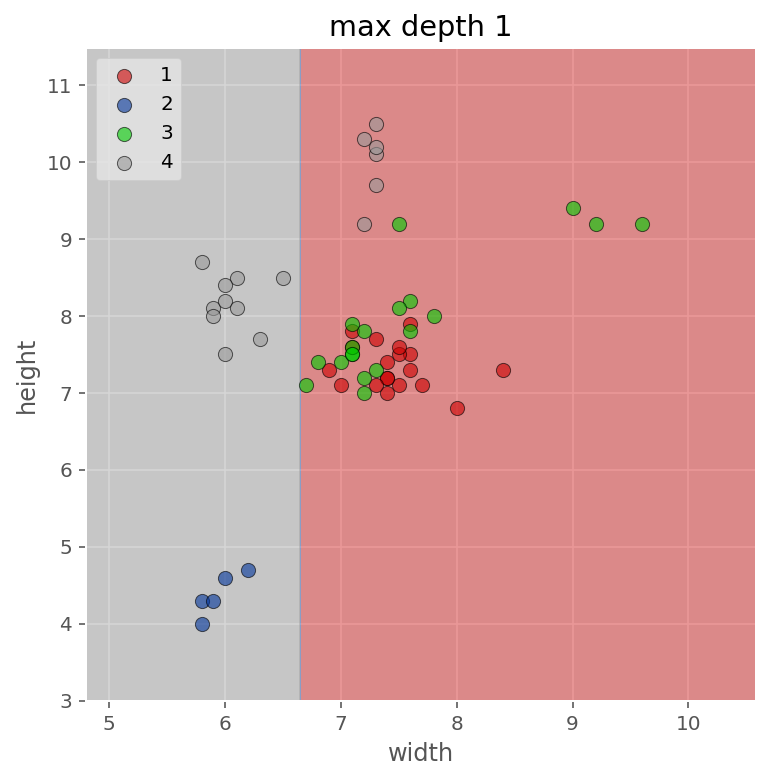

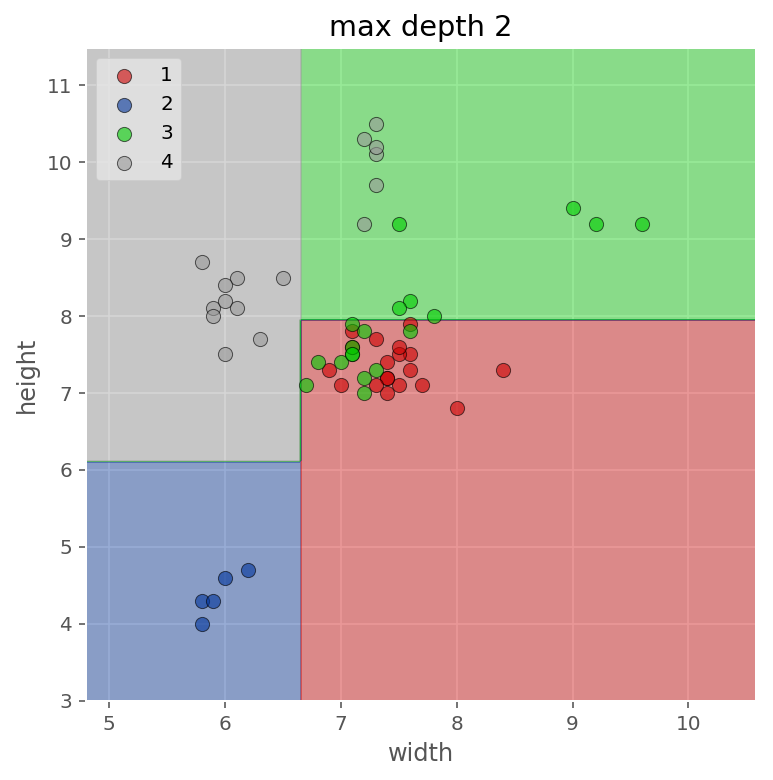

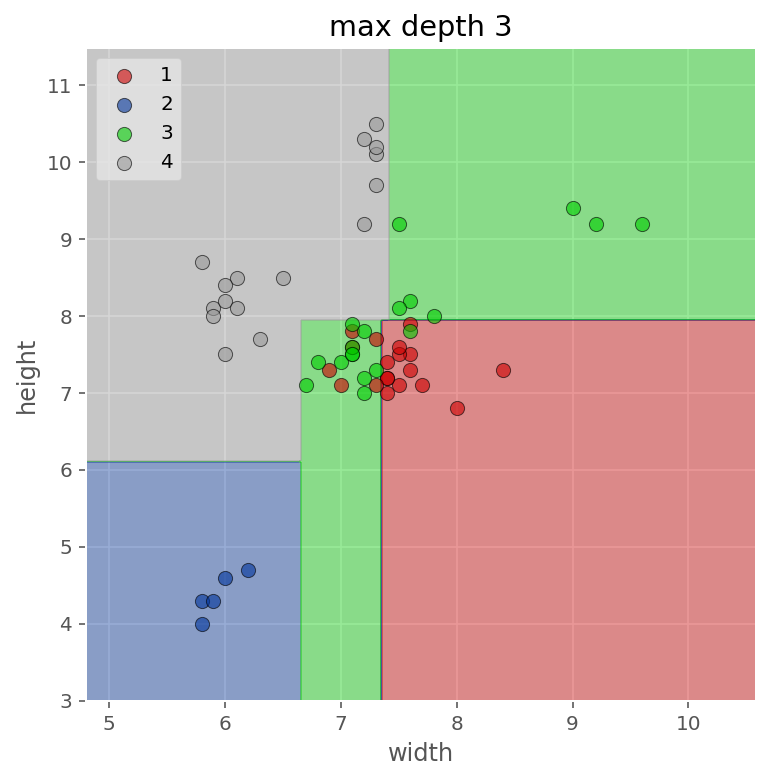

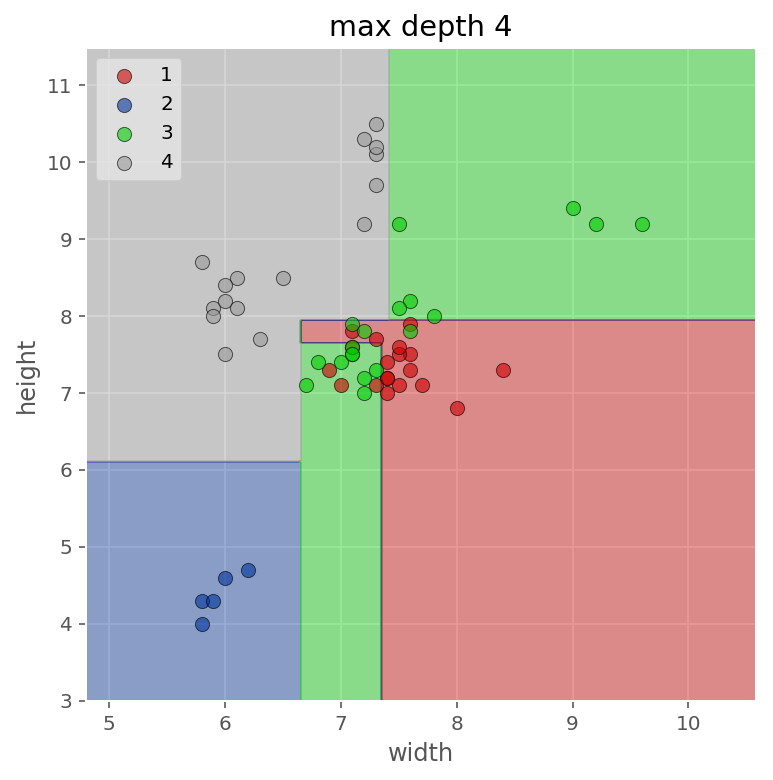

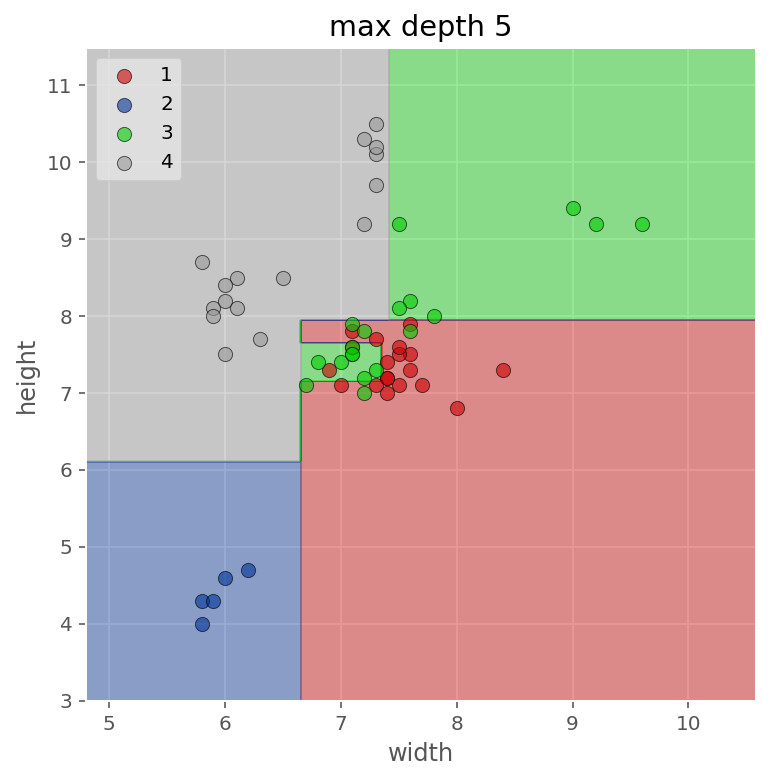

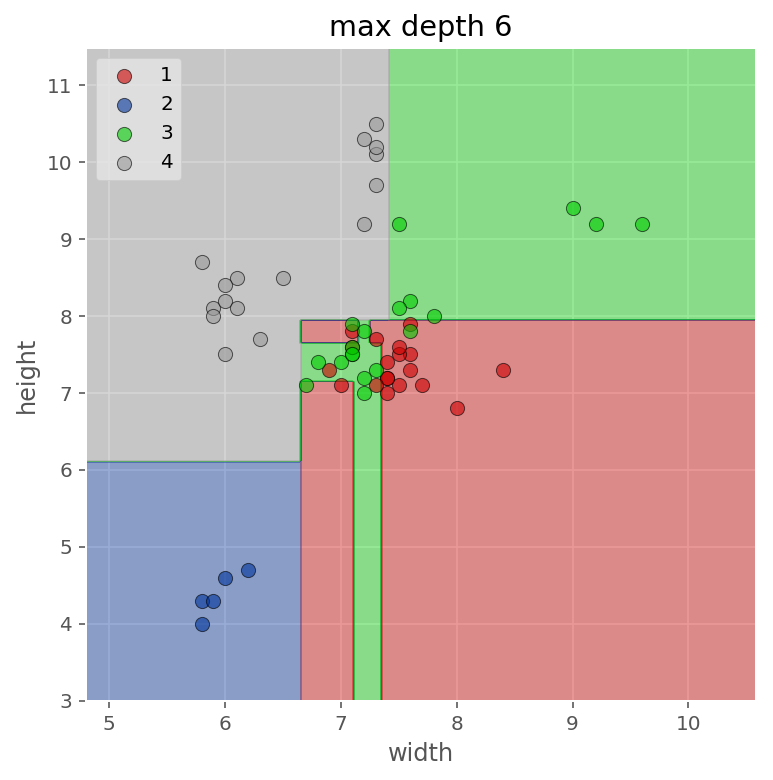

In [10]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

for i in range(1,7):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    dt.fit(X_train, y_train)

    plot_decision(X=X_combined, y=y_combined, classifier=dt)
    plt.title("max depth {}".format(i))
    plt.xlabel('width')
    plt.ylabel('height')
    plt.legend(loc='upper left')
    plt.show()

In [11]:
from IPython.display import Image, display
from IPython.core.display import HTML

dot_data = export_graphviz(dtree, out_file=None, filled=True, rounded=True,
                                feature_names=["width", "height"],  
                                class_names=['apple', 'mandarin', 'orange', 'lemon'])
graph = pydotplus.graph_from_dot_data(dot_data)
svg = graph.create_svg()
HTML(svg.decode("utf-8"))

# Overfitting vs underfitting

![](http://i.imgur.com/2q85n9s.png)

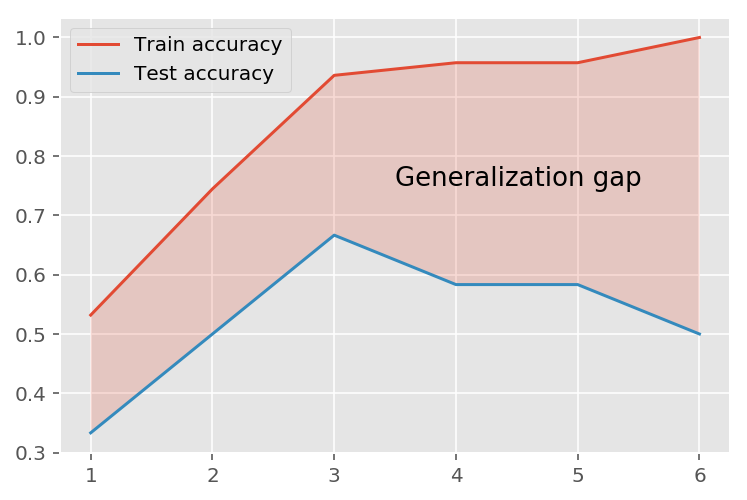

In [13]:
def fit_and_validate(depth, X_train, X_test, y_train, y_test):    
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    dtree.fit(X_train, y_train)
    
    y_pred_test = dtree.predict(X_test)
    y_pred_train = dtree.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    return train_accuracy, test_accuracy

depths = list(range(1, 7))
accs = list(zip(*[fit_and_validate(d, X_train, X_test, y_train, y_test) for d in depths]))

plt.plot(depths, accs[0], label="Train accuracy")
plt.plot(depths, accs[1], label="Test accuracy")
plt.fill_between(depths, accs[0], accs[1], alpha=0.2)
plt.text(3.5, 0.75, "Generalization gap", fontsize=13)
plt.legend();

Here's the takeaway: Models can suffer from either:

Overfitting: capturing spurious patterns that won't recur in the future, leading to less accurate predictions, or
Underfitting: failing to capture relevant patterns, again leading to less accurate predictions.
We use validation data, which isn't used in model training, to measure a candidate model's accuracy. This lets us try many candidate models and keep the best one.

# Random forest

In [14]:
credit_cards = pd.read_csv('creditcard/creditcard.csv')

feature_cols = ['Time'] + ['V%s' % i for i in range(1, 29)] + ['Amount']

X = credit_cards[feature_cols]
y = credit_cards['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
X_train[:5]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,-0.644896,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,12.95
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,0.032481,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,25.57
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.355216,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,6.90
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,-0.216247,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,4.55
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.134542,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,3.79


In [16]:
print("y unique values: {}\n".format(y_train.unique()))
print("y count: {}\n".format(y_train.count()))
print("y value counts:")
print(y_train.value_counts())

y unique values: [0 1]

y count: 227845

y value counts:
0    227454
1       391
Name: Class, dtype: int64


Decision trees leave you with a difficult decision. A deep tree with lots of leaves will overfit because each prediction is coming from historical data from only the few houses at its leaf. But a shallow tree with few leaves will perform poorly because it fails to capture as many distinctions in the raw data.

Even today's most sophisticated modeling techniques face this tension between underfitting and overfitting. But, many models have clever ideas that can lead to better performance. We'll look at the random forest as an example.

The random forest uses many trees, and it makes a prediction by averaging the predictions of each component tree. It generally has much better predictive accuracy than a single decision tree and it works well with default parameters. If you keep modeling, you can learn more models with even better performance, but many of those are sensitive to getting the right parameters.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)

y_pred_train = forest_model.predict(X_train)
y_pred_test = forest_model.predict(X_test)

count_misclassified = (y_test != y_pred_test).sum()
print('Misclassified samples: {}, total samples: {}'.format(count_misclassified, len(y_test)))

y_pred_test_proba = forest_model.predict_proba(X_test)
print('AuROC: {}'.format(roc_auc_score(y_test, y_pred_test_proba[:,1])))

print(confusion_matrix(y_test, y_pred_test))

Misclassified samples: 32, total samples: 56962
AuROC: 0.9352903493511447
[[56854     7]
 [   25    76]]


# Gradient Boosted Trees

XGBoost is the leading model for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos). XGBoost models dominate many Kaggle competitions.

To reach peak accuracy, XGBoost models require more knowledge and model tuning than techniques like Random Forest. XGBoost is an implementation of the Gradient Boosted Decision Trees algorithm (scikit-learn has another version of this algorithm, but XGBoost has some technical advantages.) What is Gradient Boosted Decision Trees? We'll walk through a diagram.

![](https://i.imgur.com/e7MIgXk.png)

We go through cycles that repeatedly builds new models and combines them into an ensemble model. We start the cycle by calculating the errors for each observation in the dataset. We then build a new model to predict those. We add predictions from this error-predicting model to the "ensemble of models."

To make a prediction, we add the predictions from all previous models. We can use these predictions to calculate new errors, build the next model, and add it to the ensemble.

There's one piece outside that cycle. We need some base prediction to start the cycle. In practice, the initial predictions can be pretty naive. Even if it's predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.

In [18]:
from xgboost import XGBClassifier

forest_model = XGBClassifier(random_state=1)
forest_model.fit(X_train, y_train)

y_pred_train = forest_model.predict(X_train)
y_pred_test = forest_model.predict(X_test)

count_misclassified = (y_test != y_pred_test).sum()
print('Misclassified samples: {}, total samples: {}'.format(count_misclassified, len(y_test)))

y_pred_test_proba = forest_model.predict_proba(X_test)
print('AuROC: {}'.format(roc_auc_score(y_test, y_pred_test_proba[:,1])))

print(confusion_matrix(y_test, y_pred_test))

/home/kraken/.conda/envs/html2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kraken/.conda/envs/html2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Misclassified samples: 31, total samples: 56962
AuROC: 0.9841712315302158
[[56851    10]
 [   21    80]]


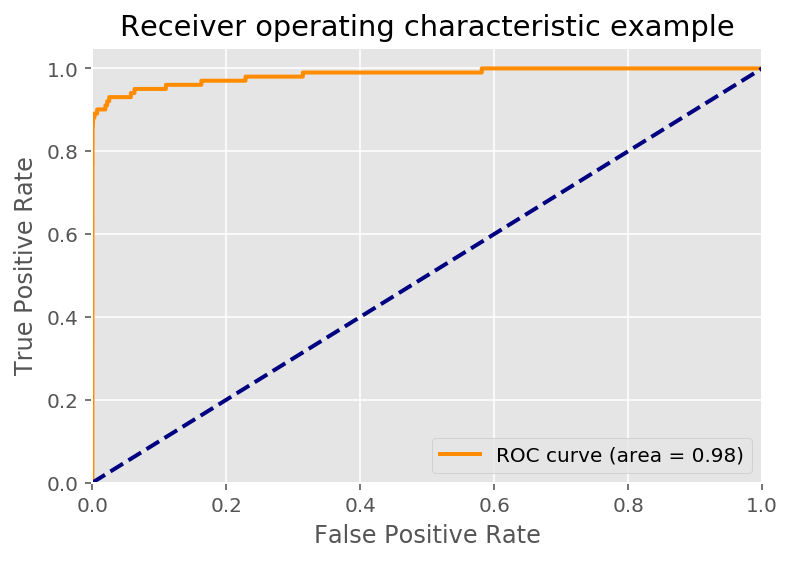

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_true=y_test, y_score=y_pred_test_proba[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
y_test.sum() / len(y_test) * 100

0.1773111899160844

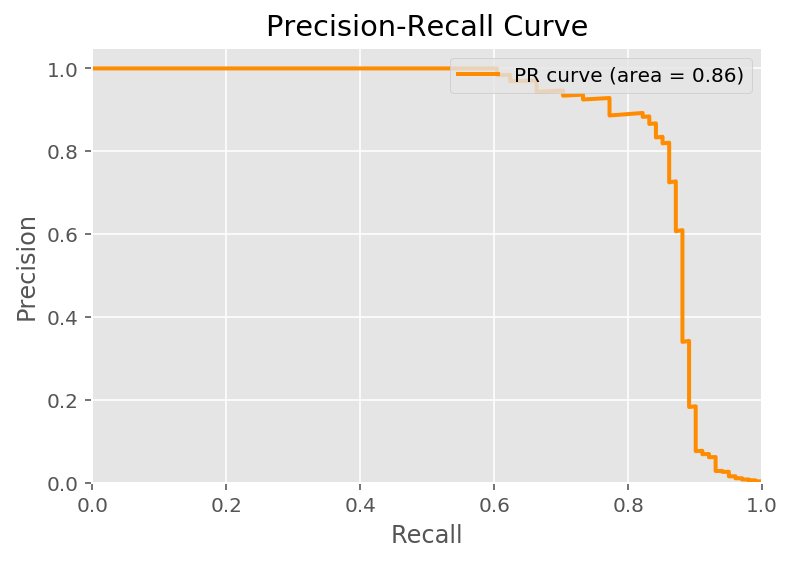

In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, thr = precision_recall_curve(y_true=y_test, probas_pred=y_pred_test_proba[:,1])

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

#### Question 1: What should the PR curve look like for a random classifier?

#### Question 2: How to choose the best threshold for classifying observations as positive?

Further reading on ROC curves vs Precision-Recall curves with thorough explanation why ROC might not be appropriate in an imbalanced classes setting - https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/